# Forecast skill assessment for Hydro Tasmania
From the 2020 HydroTas contract:
> Skill pathway and averaging  (estimated proportion of workload: 25%)
> * Assess skill of tropical sources of predictable signal: ENSO, IOD 
> * Assess skill of teleconnectors: thermal wind, jet stream 
> * Assess skill of gridded variables over Tasmania: rainfall, surface temperature, 850hPa temperature, 10m wind 
> * Assess skill of gridded variables as a function of averaging period: month, season, year, 2-years, 5-years 
> 
> Dry and wet extremes in hindcasts (estimated proportion of workload 10%)
> * Identify the major multiyear dry and wet periods for western Tasmania over the hindcast period since 1960. 
> * Assess forecast skill as a function of lead time for dry and wet to assess their relative predictability.

Carry through three anomalies:
> **unfair bias corrected** - anomalies are computed relative to each dataset's own climatology. Where the dataset is a forecast, climatologies are a function of both initial month and lead time \
> **unfair bias and std corrected** - anomalies are computed relative to each dataset's own climatology and are scaled by the ratio of the standard deviations of the observations and the model over the climatological period. Where the dataset is a forecast, climatologies are a function of both initial month and lead time. Note, the std correction is done on a *per member basis*. If it is done based on the std of the ensemble mean, the adjusted variability of individual members is over-inflated due to cancellation (particularly at long leads) of variability in the ensemble mean. \
> **biased** - anomalies are computed relative to an "observed" climatology

# Notebook params

In [1]:
tmp_dir = '/scratch1/squ027/tmp/f4_verif_iod.'
variable_name = 'IOD'

In [2]:
import doppyo
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import f5_verif_local_funcs as lf
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from f5_verif_local_funcs import test_period, clim_period, stacked_init_dates, monthly_avgs, n_bootstraps, alpha

import warnings
warnings.filterwarnings("ignore")

xr.set_options(display_style="html");
xr.set_options(keep_attrs=True);

In [3]:
rc_params = {'figure.figsize'      : (17, 8),
             'figure.titlesize'    : 12,
             'axes.titlesize'      : 'medium',
             'font.size'           : 12,
             'font.family'         : 'sans serif',
             'font.serif'          : 'Helvetica',
             'legend.fontsize'     : 10,
             'legend.handlelength' : 2,
             'legend.labelspacing' : 0.25, 
             'lines.linewidth'     : 1.5,
             'lines.markersize'    : 3,
             'hatch.linewidth'     : 0.75,
             'hatch.color'         : (0.3,0.3,0.3)}

# Spin up a cluster

In [4]:
cluster = SLURMCluster(walltime='01:00:00', cores=6, memory='10GB', job_extra=['--qos="express"'])

In [5]:
cluster.scale(n=1)

In [6]:
client = Client(cluster)
client

Client Scheduler: tcp://152.83.81.83:35341 Dashboard: http://152.83.81.83:45093/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Load the data

In [7]:
scratch_dir = '/scratch1/projects/dcfp/data/'
hcsts_ds = {}

hcsts_ds['CAFE-f5'] = lf.as_datetime64(
                    lf.similarize(xr.open_zarr(scratch_dir+'csiro-dcfp-cafe-f5/ocean_month.zarr',
                                               consolidated=True),
                                  time_dim_freq='MS',
                                  time_name='init_date',
                                  add_target_times=True,
                                  lead_time_freq='MS',
                                  fix_longitudes=True), 
                               time_dim='init_date')

hcsts_ds['GFDL-CM2.1'] = lf.as_datetime64(
                    lf.similarize(xr.open_zarr(scratch_dir+'csiro-dcfp-cmip5dec-gfdl_cm2p1/ocean_month.zarr',
                                                consolidated=True).drop(['lat_tt','lat_tu','lat_ut','lat_uu',
                                                                         'lon_tt','lon_tu','lon_ut','lon_uu']),
                                  transform_names={'tos' : 'sst'},
                                  shift_by={'tos': -273.15},
                                  time_dim_freq='MS',
                                  time_name='init_date',
                                  add_target_times=True,
                                  lead_time_freq='MS',
                                  fix_longitudes=True),
                                 time_dim='init_date')

hcsts_ds['CMC-CanCM4'] = lf.as_datetime64(
                    lf.similarize(xr.open_zarr(scratch_dir+'csiro-dcfp-cmip5dec-cmc_cancm4/ocean_month.zarr',
                                               consolidated=True),
                                  transform_names={'tos' : 'sst'},
                                  shift_by={'tos': -273.15},
                                  time_dim_freq='MS',
                                  time_name='init_date',
                                  add_target_times=True,
                                  lead_time_freq='MS',
                                  fix_longitudes=True),
                                time_dim='init_date')

In [8]:
obsv_ds = lf.as_datetime64(
                    lf.similarize(xr.decode_cf(xr.open_zarr(scratch_dir+'csiro-dcfp-hadisst/hadisst_month.zarr',
                                                            consolidated=True,
                                                            decode_cf=False),
                                               use_cftime=True),
                                  time_dim_freq='MS',
                                  fix_longitudes=True),
                        time_dim='time')

In [9]:
co2 = lf.get_rolling_leadtime_averages(
    doppyo.utils.stack_by_init_date(xr.open_dataset('co2_gblannualdata.nc')['co2_conc'],
                                    lf.stacked_init_dates,
                                     120),
                               lf.monthly_avgs)

# Prepare variable/index to be assessed

In [10]:
obsv, obsv_clim = lf.prepare_obsv(obsv_ds['sst'],
                                  diagnostic_function=doppyo.diagnostic.dmi,
                                  leadtime_resample_function=lf.get_rolling_leadtime_averages,
                                  leadtime_resample_kwargs={'list_of_months_to_average': 
                                                            lf.monthly_avgs},
                                  anomalize='last',
                                  compute=False)

obsv_noco2 = lf.remove_co2_trend(obsv, co2)

In [11]:
hcsts = {hcst_name: lf.prepare_hcst(hcsts_ds[hcst_name]['sst'], 
                                    hcst_name,
                                    obsv_clim,
                                    obsv,
                                    diagnostic_function=doppyo.diagnostic.dmi,
                                    leadtime_resample_function=lf.get_rolling_leadtime_averages,
                                    leadtime_resample_kwargs={'list_of_months_to_average': 
                                                              lf.monthly_avgs},
                                    anomalize='last',
                                    compute=False) for hcst_name in hcsts_ds.keys()}

hcsts_noco2 = {hcst_name: lf.remove_co2_trend(hcsts[hcst_name], co2) for hcst_name in hcsts.keys()}

# Compute skill metrics

In [12]:
ACC = {hcst_name: lf.get_skill_and_signif(
    hcsts[hcst_name],
    obsv,
    lf.get_Pearson_corrcoeff, 
    no_skill_value=0, 
    alpha=alpha, 
    transform=lf.Fisher_z, 
    bootstrap_kwargs={'n_resamples': n_bootstraps, 
                      'n_dates': len(hcsts[hcst_name].init_date), 
                      'n_block_dates': 5, 
                      'n_ensembles': len(hcsts[hcst_name].ensemble)}, 
    skill_metric_kwargs={'over_dims': 'init_date'}) for hcst_name in hcsts.keys()}

ACC_noco2 = {hcst_name: lf.get_skill_and_signif(
    hcsts_noco2[hcst_name],
    obsv_noco2,
    lf.get_Pearson_corrcoeff, 
    no_skill_value=0, 
    alpha=alpha, 
    transform=lf.Fisher_z, 
    bootstrap_kwargs={'n_resamples': n_bootstraps, 
                      'n_dates': len(hcsts_noco2[hcst_name].init_date), 
                      'n_block_dates': 5, 
                      'n_ensembles': len(hcsts_noco2[hcst_name].ensemble)}, 
    skill_metric_kwargs={'over_dims': 'init_date'}) for hcst_name in hcsts_noco2.keys()}

In [13]:
AmpBias = {hcst_name: (lf.get_amplitude_bias(
    hcsts[hcst_name],
    obsv,
    'init_date'), None) for hcst_name in hcsts.keys()}

AmpBias_noco2 = {hcst_name: (lf.get_amplitude_bias(
    hcsts_noco2[hcst_name],
    obsv_noco2,
    'init_date'), None) for hcst_name in hcsts_noco2.keys()}

In [14]:
MeanBias = {hcst_name: (lf.get_mean_bias(
    hcsts[hcst_name],
    obsv,
    'init_date'), None) for hcst_name in hcsts.keys()}

MeanBias_noco2 = {hcst_name: (lf.get_mean_bias(
    hcsts_noco2[hcst_name],
    obsv_noco2,
    'init_date'), None) for hcst_name in hcsts_noco2.keys()}

In [15]:
MSSS = {hcst_name: lf.get_skill_and_signif(
    hcsts[hcst_name],
    obsv,
    lf.get_MSSS, 
    no_skill_value=0, 
    alpha=alpha, 
    transform=None, 
    bootstrap_kwargs={'n_resamples': n_bootstraps, 
                      'n_dates': len(hcsts[hcst_name].init_date), 
                      'n_block_dates': 5, 
                      'n_ensembles': len(hcsts[hcst_name].ensemble)}, 
    skill_metric_kwargs={'over_dims': 'init_date'}) for hcst_name in hcsts.keys()}

MSSS_noco2 = {hcst_name: lf.get_skill_and_signif(
    hcsts_noco2[hcst_name],
    obsv_noco2,
    lf.get_MSSS, 
    no_skill_value=0, 
    alpha=alpha, 
    transform=None, 
    bootstrap_kwargs={'n_resamples': n_bootstraps, 
                      'n_dates': len(hcsts_noco2[hcst_name].init_date), 
                      'n_block_dates': 5, 
                      'n_ensembles': len(hcsts_noco2[hcst_name].ensemble)}, 
    skill_metric_kwargs={'over_dims': 'init_date'}) for hcst_name in hcsts_noco2.keys()}

In [16]:
anom = 'unfair bias and std corrected'
quantile_edges = [0.25, 0.75]

Gerrity = {hcst_name: lf.get_skill_and_signif(
    hcsts[hcst_name][anom],
    obsv[anom],
    lf.get_Gerrity_score, 
    no_skill_value=0, 
    alpha=alpha, 
    transform=None, 
    bootstrap_kwargs={'n_resamples': n_bootstraps, 
                      'n_dates': len(hcsts[hcst_name].init_date), 
                      'n_block_dates': 5, 
                      'n_ensembles': len(hcsts[hcst_name].ensemble)}, 
    skill_metric_kwargs={'category_edges_cmp': [-np.inf,
                                                hcsts[hcst_name][anom].mean('ensemble') \
                                                                      .quantile(quantile_edges[0], dim='init_date') \
                                                                      .drop('quantile'),
                                                hcsts[hcst_name][anom].mean('ensemble') \
                                                                      .quantile(quantile_edges[1], dim='init_date') \
                                                                      .drop('quantile'),
                                                np.inf],
                         'category_edges_ref': [-np.inf,
                                                obsv[anom].quantile(quantile_edges[0], dim='init_date') \
                                                                     .drop('quantile'),
                                                obsv[anom].quantile(quantile_edges[1], dim='init_date') \
                                                                     .drop('quantile'),
                                                np.inf],
                         'over_dims': 'init_date'}) for hcst_name in hcsts.keys()}

Gerrity_noco2 = {hcst_name: lf.get_skill_and_signif(
    hcsts_noco2[hcst_name][anom],
    obsv_noco2[anom],
    lf.get_Gerrity_score, 
    no_skill_value=0, 
    alpha=alpha, 
    transform=None, 
    bootstrap_kwargs={'n_resamples': n_bootstraps, 
                      'n_dates': len(hcsts_noco2[hcst_name].init_date), 
                      'n_block_dates': 5, 
                      'n_ensembles': len(hcsts_noco2[hcst_name].ensemble)}, 
    skill_metric_kwargs={'category_edges_cmp': [-np.inf,
                                                hcsts_noco2[hcst_name][anom].mean('ensemble') \
                                                                            .quantile(quantile_edges[0], dim='init_date') \
                                                                            .drop('quantile'),
                                                hcsts_noco2[hcst_name][anom].mean('ensemble') \
                                                                            .quantile(quantile_edges[1], dim='init_date') \
                                                                            .drop('quantile'),
                                                np.inf],
                         'category_edges_ref': [-np.inf,
                                                obsv_noco2[anom].quantile(quantile_edges[0], dim='init_date') \
                                                                           .drop('quantile'),
                                                obsv_noco2[anom].quantile(quantile_edges[1], dim='init_date') \
                                                                           .drop('quantile'),
                                                np.inf],
                         'over_dims': 'init_date'}) for hcst_name in hcsts_noco2.keys()}

In [17]:
anom = 'unfair bias and std corrected'
quantile_ranges = {'IOD negative': (0,    0.25),
                   'Neutral':      (0.25, 0.75),
                   'IOD positive': (0.75, 1)}
bin_edges = np.linspace(0.1,1,10)

ROC = {}
for hcst_name in hcsts.keys():
    ROC[hcst_name] = {quantile_name: lf.get_skill_and_signif(
            xr.where((hcsts[hcst_name][anom] >= hcsts[hcst_name][anom].quantile(quantile_range[0], 
                                                                                dim=['init_date','ensemble']).drop('quantile')) & 
                     (hcsts[hcst_name][anom] <  hcsts[hcst_name][anom].quantile(quantile_range[1], 
                                                                                dim=['init_date','ensemble']).drop('quantile')), 
                     1, 0).where(hcsts[hcst_name][anom].notnull()),
            xr.where((obsv[anom] >= obsv[anom].quantile(quantile_range[0], 
                                                        dim='init_date').drop('quantile')) & 
                     (obsv[anom] <  obsv[anom].quantile(quantile_range[1], 
                                                        dim='init_date').drop('quantile')), 
                     1, 0).where(obsv[anom].notnull()), 
            lf.get_ROC_score, 
            no_skill_value=0.5, 
            alpha=alpha, 
            transform=None, 
            bootstrap_kwargs={'n_resamples': n_bootstraps, 
                              'n_dates': len(hcsts[hcst_name].init_date), 
                              'n_block_dates': 5, 
                              'n_ensembles': len(hcsts[hcst_name].ensemble)}, 
            skill_metric_kwargs={'over_dims': 'init_date',
                                 'probability_bin_edges': bin_edges}) for quantile_name, quantile_range in quantile_ranges.items()}
    
ROC_noco2 = {}
for hcst_name, hcst in hcsts_noco2.items():
    ROC_noco2[hcst_name] = {quantile_name: lf.get_skill_and_signif(
            xr.where((hcsts_noco2[hcst_name][anom] >= hcsts_noco2[hcst_name][anom].quantile(quantile_range[0], 
                                                                                            dim=['init_date','ensemble']).drop('quantile')) & 
                     (hcsts_noco2[hcst_name][anom] <  hcsts_noco2[hcst_name][anom].quantile(quantile_range[1], 
                                                                                            dim=['init_date','ensemble']).drop('quantile')), 
                     1, 0).where(hcsts_noco2[hcst_name][anom].notnull()),
            xr.where((obsv_noco2[anom] >= obsv_noco2[anom].quantile(quantile_range[0], 
                                                                    dim='init_date').drop('quantile')) & 
                     (obsv_noco2[anom] <  obsv_noco2[anom].quantile(quantile_range[1], 
                                                                    dim='init_date').drop('quantile')), 
                     1, 0).where(obsv_noco2[anom].notnull()), 
            lf.get_ROC_score, 
            no_skill_value=0.5, 
            alpha=alpha, 
            transform=None, 
            bootstrap_kwargs={'n_resamples': n_bootstraps, 
                              'n_dates': len(hcsts_noco2[hcst_name].init_date), 
                              'n_block_dates': 5, 
                              'n_ensembles': len(hcsts_noco2[hcst_name].ensemble)}, 
            skill_metric_kwargs={'over_dims': 'init_date',
                                 'probability_bin_edges': bin_edges}) for quantile_name, quantile_range in quantile_ranges.items()}

# Plot the skill metrics

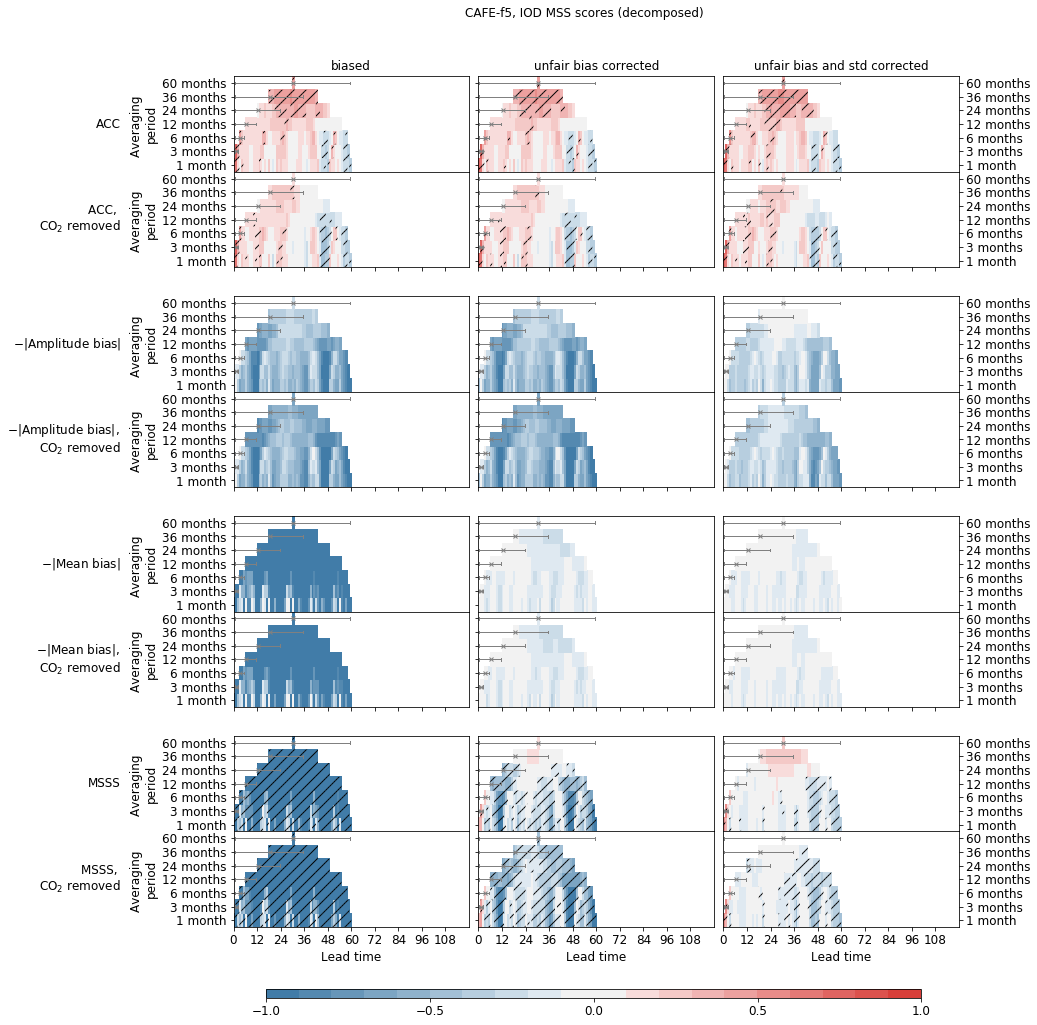

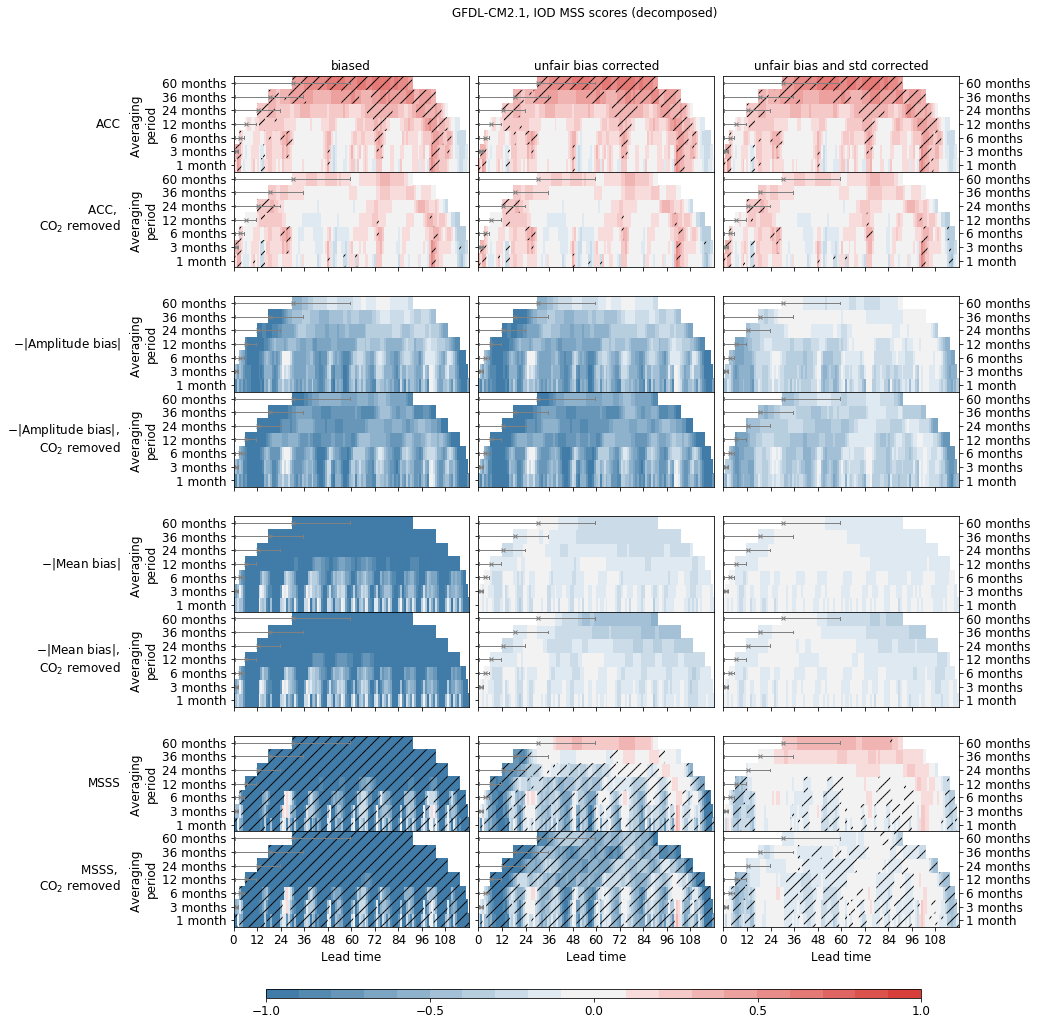

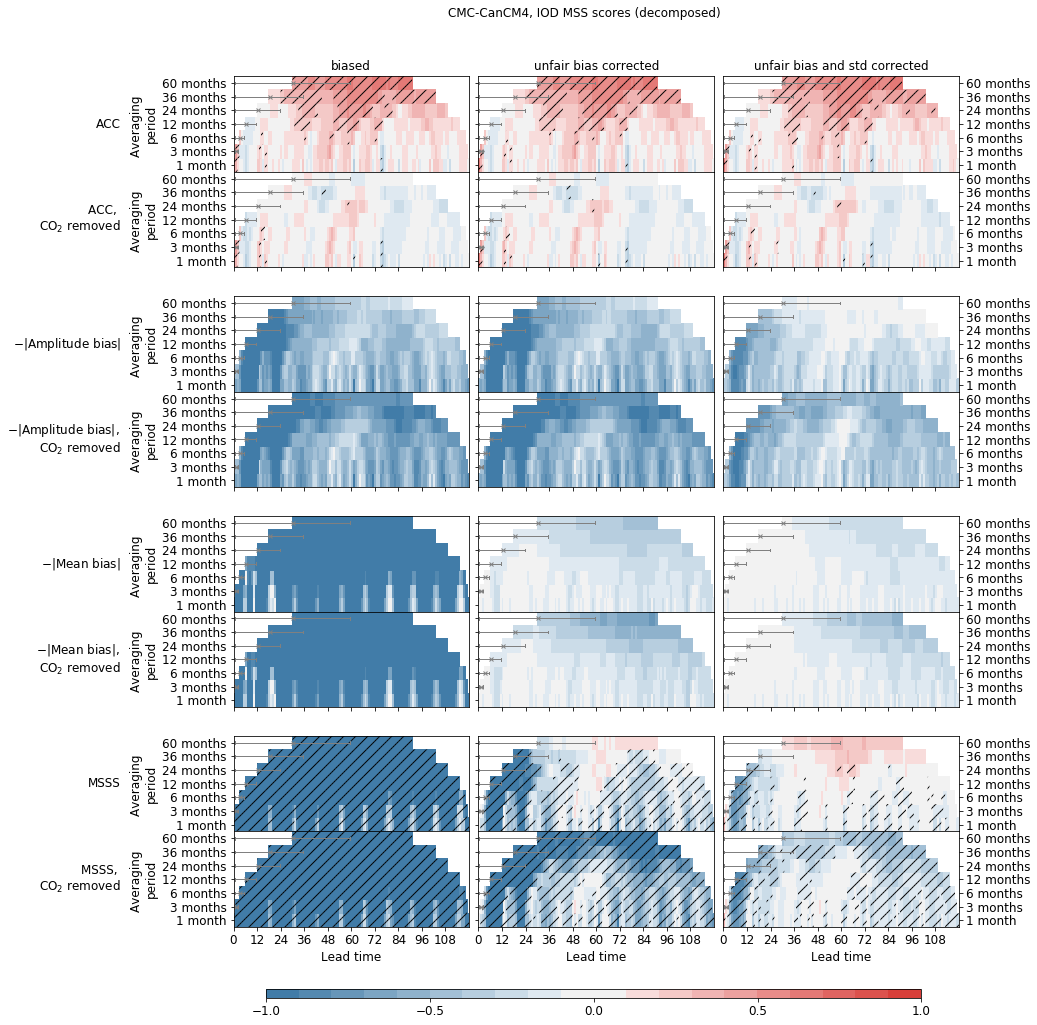

In [20]:
rc_params['figure.figsize'] = (13, 16)

with mpl.rc_context(rc=rc_params):
    for model in hcsts.keys():
        lf.plot_skill_score_avgs([ACC[model][0], 
                                  ACC_noco2[model][0], 
                                  -abs(AmpBias[model][0]),
                                  -abs(AmpBias_noco2[model][0]),
                                  -abs(MeanBias[model][0]),
                                  -abs(MeanBias_noco2[model][0]),
                                  MSSS[model][0],
                                  MSSS_noco2[model][0]], 
                                title=model+', '+variable_name+' MSS scores (decomposed)',
                                headings=['ACC', 
                                          'ACC, \nCO$_2$ removed', 
                                          '$-|$Amplitude bias$|$', 
                                          '$-|$Amplitude bias$|$, \nCO$_2$ removed', 
                                          '$-|$Mean bias$|$', 
                                          '$-|$Mean bias$|$, \nCO$_2$ removed', 
                                          'MSSS',
                                          'MSSS, \nCO$_2$ removed'],
                                stipple=[ACC[model][1], 
                                         ACC_noco2[model][1], 
                                         AmpBias[model][1],
                                         AmpBias_noco2[model][1],
                                         MeanBias[model][1],
                                         MeanBias_noco2[model][1],
                                         MSSS[model][1],
                                         MSSS_noco2[model][1]],
                                vlims=(-1, 1),
                                xlims=(0,120),
                                group_rows_by=2)
        plt.savefig('figures/'+model+'_'+variable_name+'_MSSS_decomposed.png', format='png', dpi=300, bbox_inches='tight')

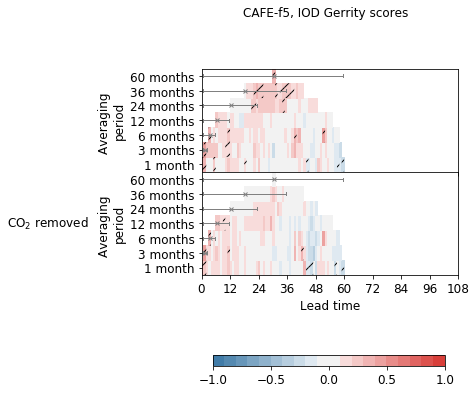

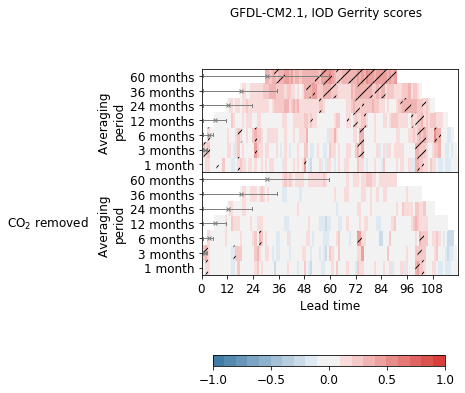

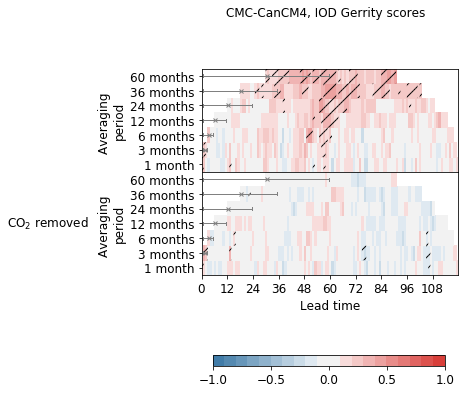

In [21]:
rc_params['figure.figsize'] = (4.6, 4.8)
rc_params['font.size'] = 12

with mpl.rc_context(rc=rc_params):
    for model in hcsts.keys():
        lf.plot_skill_score_avgs([Gerrity[model][0],
                                  Gerrity_noco2[model][0]], 
                                  title=model+', '+variable_name+' Gerrity scores',
                                  headings=['',
                                            'CO$_2$ removed'],
                                  stipple=[Gerrity[model][1],
                                           Gerrity_noco2[model][1]],
                                  vlims=(-1, 1),
                                  group_rows_by=2)
        plt.savefig('figures/'+model+'_'+variable_name+'_Gerrity.png', format='png', dpi=300, bbox_inches='tight')

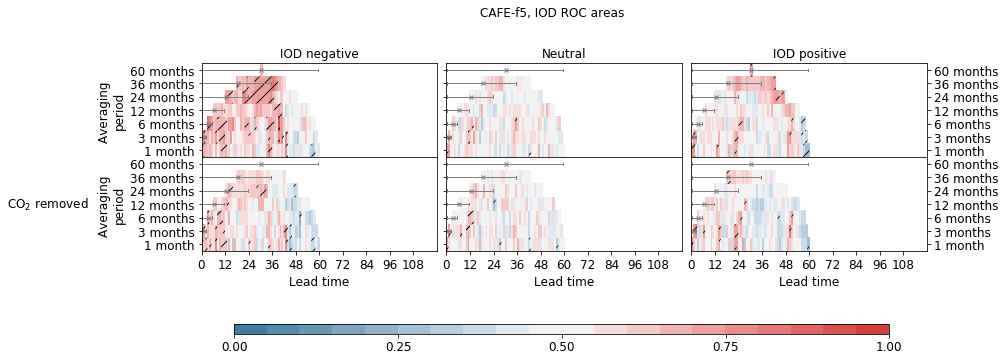

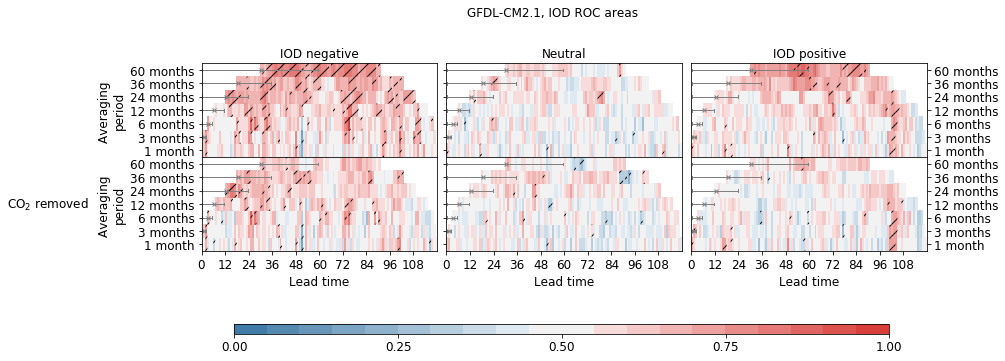

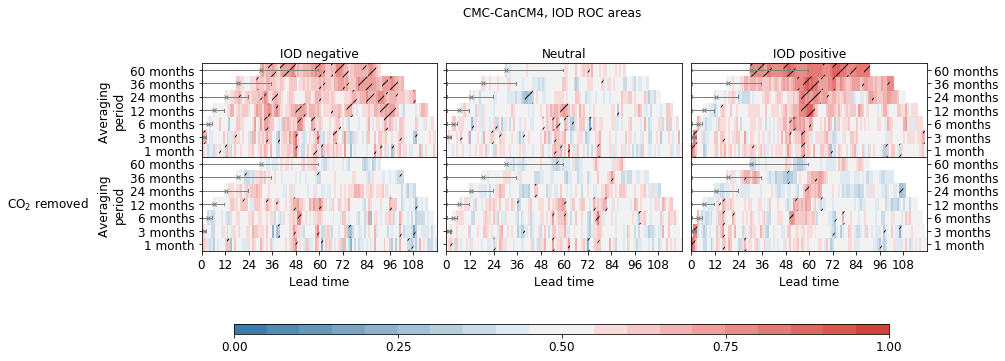

In [22]:
rc_params['figure.figsize'] = (13, 4.37)

with mpl.rc_context(rc=rc_params):
    for model in hcsts.keys():
        ROC_areas = (xr.merge([data[0]['area'].where(data[0]['area']>0).rename(name) for name, data in ROC[model].items()]),
                     xr.merge([data[1]['area'].where(data[0]['area']>0,0).rename(name) for name, data in ROC[model].items()]))
        ROC_noco2_areas = (xr.merge([data[0]['area'].where(data[0]['area']>0).rename(name) for name, data in ROC_noco2[model].items()]),
                           xr.merge([data[1]['area'].where(data[0]['area']>0,0).rename(name) for name, data in ROC_noco2[model].items()]))
        lf.plot_skill_score_avgs([ROC_areas[0],
                                  ROC_noco2_areas[0]], 
                              title=model+', '+variable_name+' ROC areas',
                              headings=['',
                                        'CO$_2$ removed'],
                              stipple=[ROC_areas[1],
                                       ROC_noco2_areas[1]],
                              vlims=(0, 1),
                              xlims=(0,120),
                              group_rows_by=2)
        plt.savefig('figures/'+model+'_'+variable_name+'_ROCarea.png', format='png', dpi=300, bbox_inches='tight')

# Plots for HydroTAS presentation

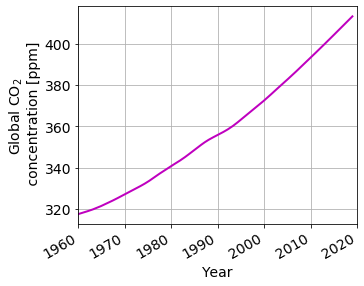

In [144]:
rc_params['figure.figsize'] = (5,4)

with mpl.rc_context(rc=rc_params):
    co2.sel(time_scale=60, lead_time=30).plot(color='m', linewidth=2)
#     plt.ylim(-0.18, 0.18)
    plt.ylabel('Global CO$_2$ \n concentration [ppm]')
    plt.xlabel('Year')
    plt.title('')
    plt.xticks([np.datetime64(date) for date in pd.date_range(start='1960', end='2020', freq='10AS')],
               labels=[date.strftime('%Y') for date in pd.date_range(start='1960', end='2020', freq='10AS')])
    plt.grid(True)
    plt.xlim('1960','2020')
    plt.savefig('figures/co2.png', format='png', dpi=300, bbox_inches='tight')

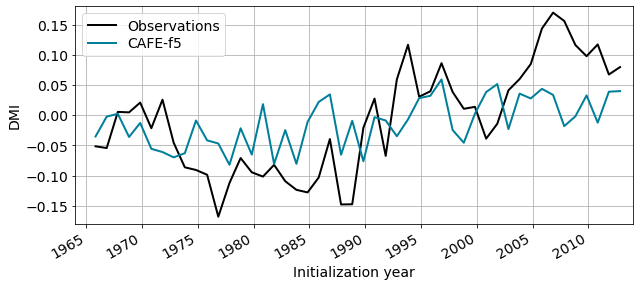

In [162]:
rc_params['figure.figsize'] = (10,4)
rc_params['legend.fontsize'] = 14

with mpl.rc_context(rc=rc_params):
    obsv['unfair bias and std corrected'].sel(time_scale=60, lead_time=30, init_date=hcsts['CAFE-f5'].init_date.values).plot(color='k', linewidth=2)
    hcsts['CAFE-f5']['unfair bias and std corrected'].sel(time_scale=60, lead_time=30).mean('ensemble').plot(color=(0,127/255,155/255), linewidth=2)
    plt.ylim(-0.18, 0.18)
    plt.ylabel('DMI')
    plt.xlabel('Initialization year')
    plt.title('')
    plt.legend(['Observations','CAFE-f5'], loc='upper left')
    plt.xticks([np.datetime64(date) for date in pd.date_range(start='1960', end='2020', freq='5AS')],
               labels=[date.strftime('%Y') for date in pd.date_range(start='1960', end='2020', freq='5AS')])
    plt.grid(True)
    plt.xlim('1964','2014')
    plt.savefig('figures/CAFE-f5_IOD_timescale60_lead30.png', format='png', dpi=300, bbox_inches='tight')

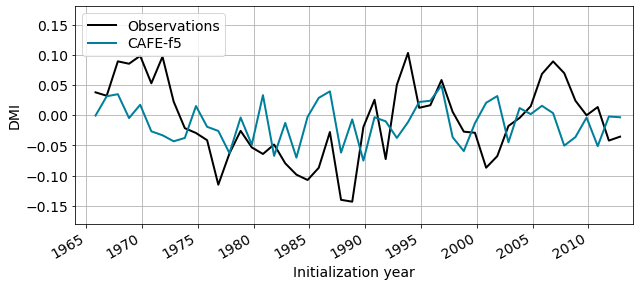

In [163]:
rc_params['figure.figsize'] = (10,4)
rc_params['legend.fontsize'] = 14

with mpl.rc_context(rc=rc_params):
    obsv_noco2['unfair bias and std corrected'].sel(time_scale=60, lead_time=30, init_date=hcsts['CAFE-f5'].init_date.values).plot(color='k', linewidth=2)
    hcsts_noco2['CAFE-f5']['unfair bias and std corrected'].sel(time_scale=60, lead_time=30).mean('ensemble').plot(color=(0,127/255,155/255), linewidth=2)
    plt.ylim(-0.18, 0.18)
    plt.ylabel('DMI')
    plt.xlabel('Initialization year')
    plt.title('')
    plt.legend(['Observations','CAFE-f5'], loc='upper left')
    plt.xticks([np.datetime64(date) for date in pd.date_range(start='1960', end='2020', freq='5AS')],
               labels=[date.strftime('%Y') for date in pd.date_range(start='1960', end='2020', freq='5AS')])
    plt.grid(True)
    plt.xlim('1964','2014')
    plt.savefig('figures/CAFE-f5_IOD_timescale60_lead30_noco2.png', format='png', dpi=300, bbox_inches='tight')

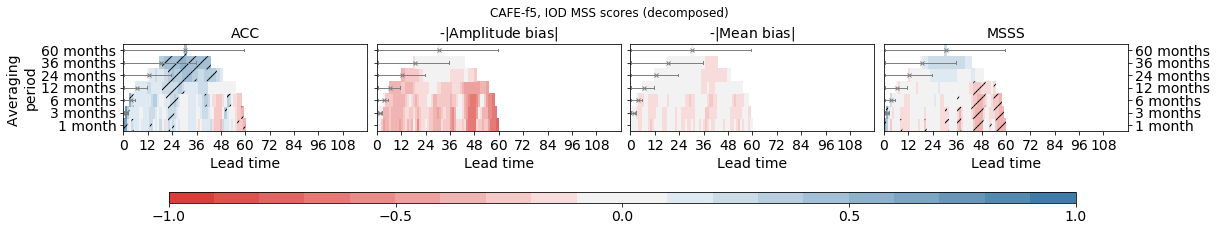

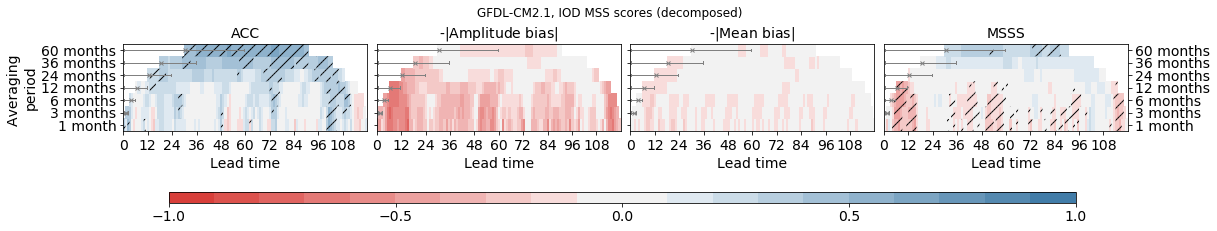

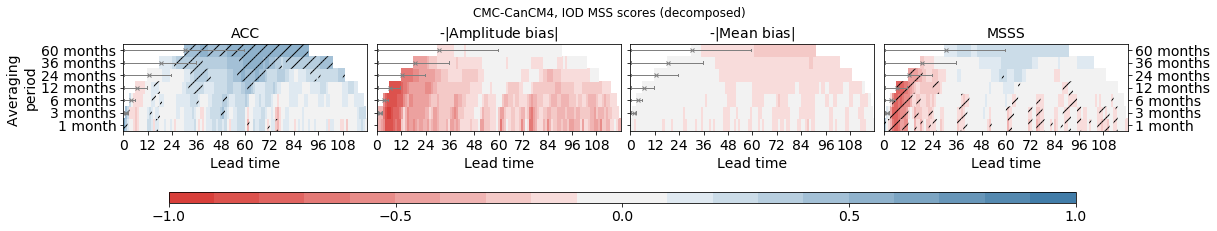

In [166]:
anom = 'unfair bias and std corrected'
rc_params['figure.figsize'] = (18, 2.54)

with mpl.rc_context(rc=rc_params):
    for model in hcsts.keys():
        lf.plot_skill_score_avgs([xr.merge([ACC[model][0][anom].rename('ACC'), 
                                            -abs(AmpBias[model][0][anom].rename('-$|$Amplitude bias$|$')),
                                            -abs(MeanBias[model][0][anom].rename('-$|$Mean bias$|$')),
                                            MSSS[model][0][anom].rename('MSSS')])], 
                                title=model+', '+variable_name+' MSS scores (decomposed)',
                                headings=[''],
                                stipple=[xr.merge([ACC[model][1][anom].rename('ACC'), 
                                                   (False*ACC[model][1][anom]).rename('-$|$Amplitude bias$|$'),
                                                   (False*ACC[model][1][anom]).rename('-$|$Mean bias$|$'),
                                                   MSSS[model][1][anom].rename('MSSS')])], 
                                vlims=(-1, 1),
                                xlims=(0,120),
                                group_rows_by=1)
        plt.savefig('HydroTas_figures/'+model+'_'+variable_name+'_MSSS_decomposed.png', format='png', dpi=300, bbox_inches='tight')

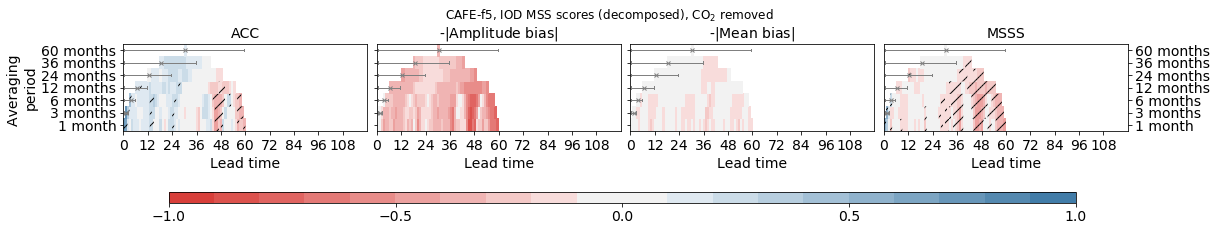

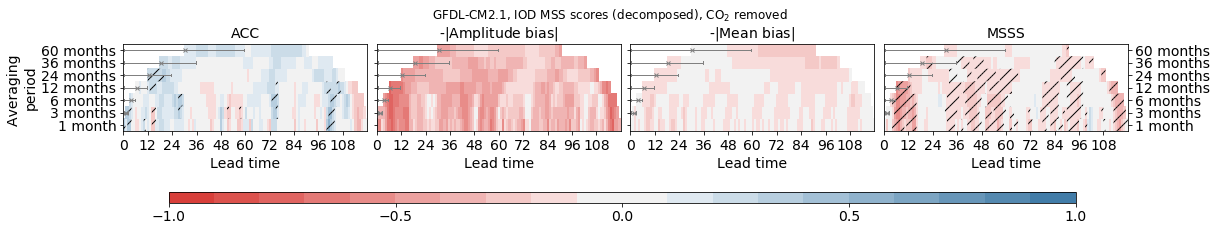

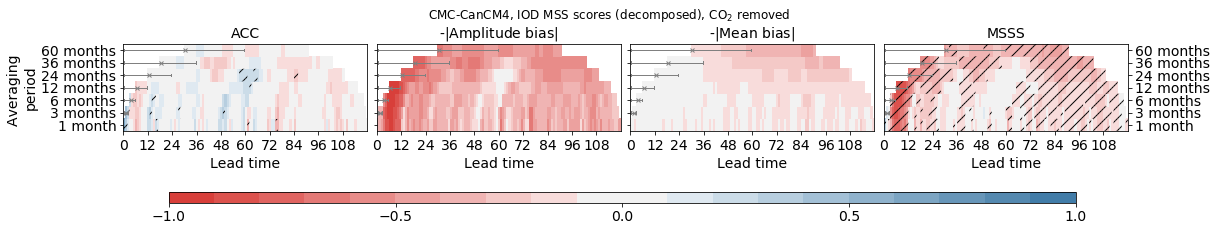

In [169]:
anom = 'unfair bias and std corrected'
rc_params['figure.figsize'] = (18, 2.54)

with mpl.rc_context(rc=rc_params):
    for model in hcsts.keys():
        lf.plot_skill_score_avgs([xr.merge([ACC_noco2[model][0][anom].rename('ACC'), 
                                            -abs(AmpBias_noco2[model][0][anom].rename('-$|$Amplitude bias$|$')),
                                            -abs(MeanBias_noco2[model][0][anom].rename('-$|$Mean bias$|$')),
                                            MSSS_noco2[model][0][anom].rename('MSSS')])], 
                                title=model+', '+variable_name+' MSS scores (decomposed), CO$_2$ removed',
                                headings=[''],
                                stipple=[xr.merge([ACC_noco2[model][1][anom].rename('ACC'), 
                                                   (False*ACC_noco2[model][1][anom]).rename('-$|$Amplitude bias$|$'),
                                                   (False*ACC_noco2[model][1][anom]).rename('-$|$Mean bias$|$'),
                                                   MSSS_noco2[model][1][anom].rename('MSSS')])], 
                                vlims=(-1, 1),
                                xlims=(0,120),
                                group_rows_by=1)
        plt.savefig('HydroTas_figures/'+model+'_'+variable_name+'_MSSS_decomposed_noco2.png', format='png', dpi=300, bbox_inches='tight')

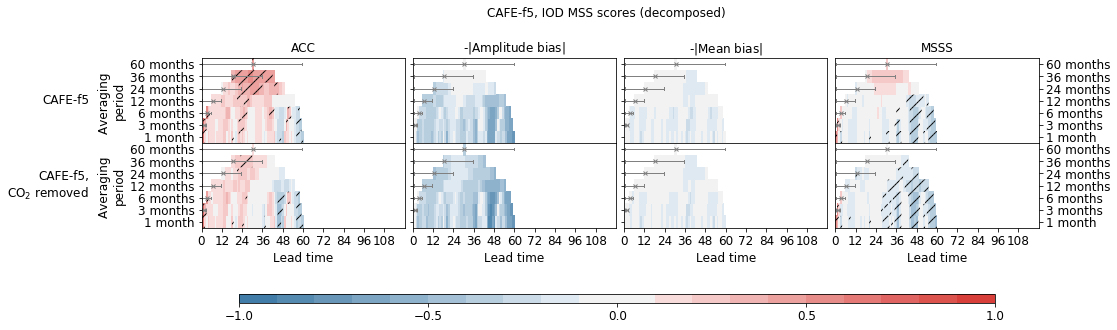

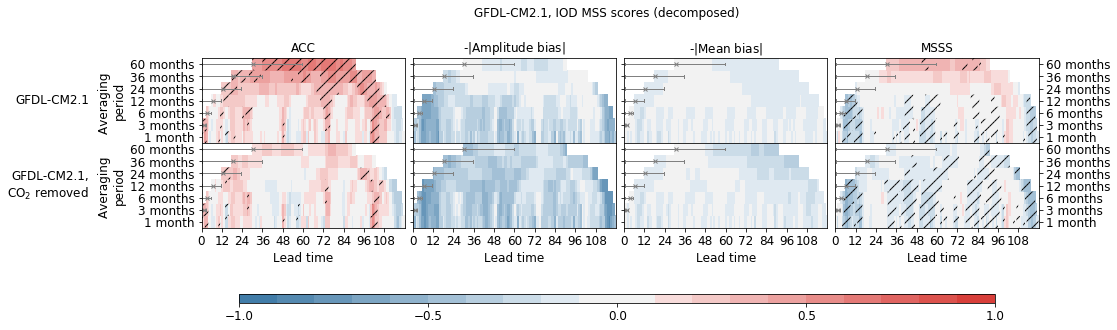

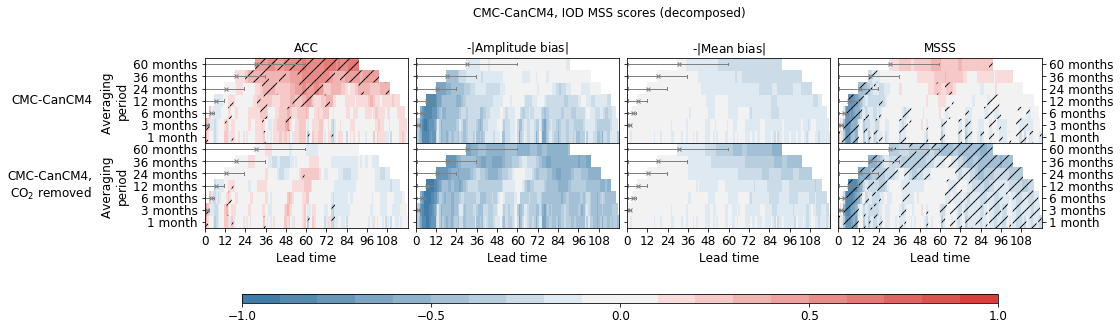

In [25]:
anom = 'unfair bias and std corrected'
rc_params['figure.figsize'] = (15, 3.95)

with mpl.rc_context(rc=rc_params):
    for model in hcsts.keys():
        lf.plot_skill_score_avgs([xr.merge([ACC[model][0][anom].rename('ACC'), 
                                            -abs(AmpBias[model][0][anom].rename('-$|$Amplitude bias$|$')),
                                            -abs(MeanBias[model][0][anom].rename('-$|$Mean bias$|$')),
                                            MSSS[model][0][anom].rename('MSSS')]),
                                  xr.merge([ACC_noco2[model][0][anom].rename('ACC'), 
                                            -abs(AmpBias_noco2[model][0][anom].rename('-$|$Amplitude bias$|$')),
                                            -abs(MeanBias_noco2[model][0][anom].rename('-$|$Mean bias$|$')),
                                            MSSS_noco2[model][0][anom].rename('MSSS')])], 
                                title=model+', '+variable_name+' MSS scores (decomposed)',
                                headings=[model,
                                          model+',\nCO$_2$ removed'],
                                stipple=[xr.merge([ACC[model][1][anom].rename('ACC'), 
                                                   (False*ACC[model][1][anom]).rename('-$|$Amplitude bias$|$'),
                                                   (False*ACC[model][1][anom]).rename('-$|$Mean bias$|$'),
                                                   MSSS[model][1][anom].rename('MSSS')]),
                                         xr.merge([ACC_noco2[model][1][anom].rename('ACC'), 
                                                   (False*ACC_noco2[model][1][anom]).rename('-$|$Amplitude bias$|$'),
                                                   (False*ACC_noco2[model][1][anom]).rename('-$|$Mean bias$|$'),
                                                   MSSS_noco2[model][1][anom].rename('MSSS')])], 
                                vlims=(-1, 1),
                                xlims=(0,120),
                                group_rows_by=2)
        plt.savefig('HydroTas_figures/'+model+'_'+variable_name+'_MSSS_decomposed.png', format='png', dpi=300, bbox_inches='tight')

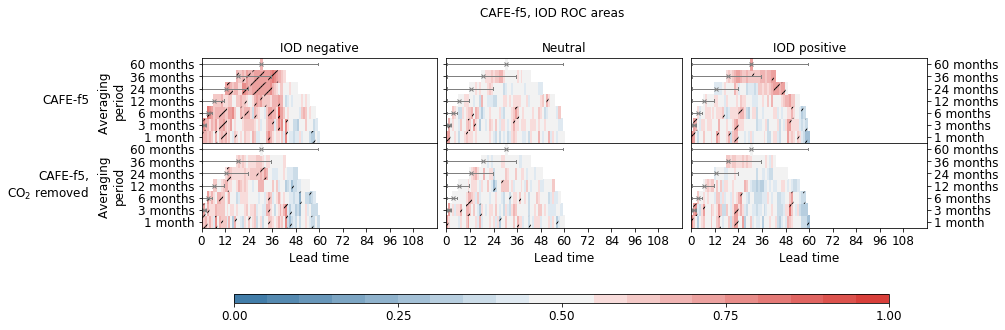

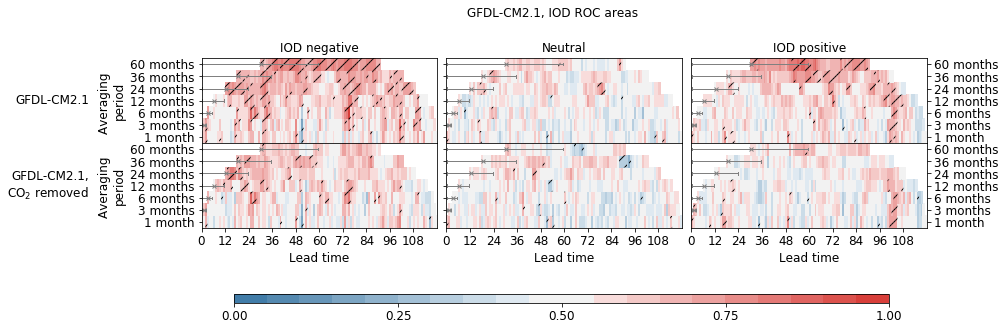

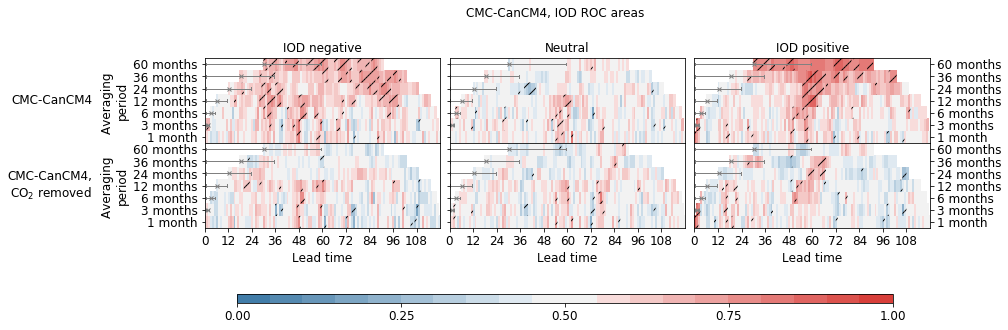

In [26]:
rc_params['figure.figsize'] = (13, 3.95)

with mpl.rc_context(rc=rc_params):
    for model in hcsts.keys():
        ROC_areas = (xr.merge([data[0]['area'].where(data[0]['area']>0).rename(name) for name, data in ROC[model].items()]),
                     xr.merge([data[1]['area'].where(data[0]['area']>0,0).rename(name) for name, data in ROC[model].items()]))
        ROC_noco2_areas = (xr.merge([data[0]['area'].where(data[0]['area']>0).rename(name) for name, data in ROC_noco2[model].items()]),
                           xr.merge([data[1]['area'].where(data[0]['area']>0,0).rename(name) for name, data in ROC_noco2[model].items()]))
        lf.plot_skill_score_avgs([ROC_areas[0],
                                  ROC_noco2_areas[0]], 
                              title=model+', '+variable_name+' ROC areas',
                              headings=[model,
                                        model+',\nCO$_2$ removed'],
                              stipple=[ROC_areas[1],
                                       ROC_noco2_areas[1]],
                              vlims=(0, 1),
                              xlims=(0,120),
                              group_rows_by=2)
        plt.savefig('HydroTas_figures/'+model+'_'+variable_name+'_ROCarea.png', format='png', dpi = 300, bbox_inches='tight')